### Importing libraries

In [3]:
# Import default libraries
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import seaborn as sns
import time
import random
import warnings
# Import Biopython utils
from Bio.PDB import PDBList, calc_angle, calc_dihedral, PPBuilder, is_aa, PDBIO, NeighborSearch, DSSP, HSExposureCB
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import IUPACData
from Bio.PDB.PDBIO import Select

### Helping functions

In [4]:
# Function for tagging residues as LIP/non-LIP
# Overwrites entries in the second dataset with LIP flag from the first dataset
def LIP_tag(ds_original, ds_residues):
    #For every protein we take the information of where LIP residue are
    for idx, row in ds_original.iterrows():
        # Bind information to correct variables
        pdb, chain, start, end = (row[0:4])
        # Get the correct slice of data which will be edited
        sliced = ((ds_residues['PDB_ID'] == pdb) 
                    & (ds_residues['CHAIN_ID'] == chain) 
                    & (ds_residues['RES_ID'] <= end) 
                    & (ds_residues['RES_ID'] >= start))
        #Now we set to 1 all the residue whose features are the one desired 
        ds_residues.loc[sliced, 'LIP'] = 1
        ds_residues.loc[sliced, 'LIP_SCORE'] = 1
        
def down_sampling(df, number_of_samples, seed = 42):
    noLIP_index = set(df[df['LIP'] == 0].index)
    indexes = set(np.arange(0, np.shape(df)[0]))
    sample = random.sample(noLIP_index, len(noLIP_index) - number_of_samples)
    new_index = indexes.difference(sample)
    df1 = df.iloc[list(new_index), :]
    return df1

# Turns an angle from radiants to degrees 
def rad_to_deg(rad_angle):
    # If the input is None, then it returns None.
    # For numerical input, the output is mapped to [-180,180]
    if rad_angle is None :
        return None
    # Computes angle in degrees
    angle = rad_angle * 180 / math.pi
    # Handles radiants conversion
    while angle > 180 :
        angle = angle - 360
    while angle < -180 :
        angle = angle + 360
    return angle

### Importing original dataset (LIP tagged sequences)

In [5]:
# Read original dataset (lips_dataset)
ds_original = pd.read_csv('./datasets/lips_dataset.txt', sep='\t')
# Define new dataset
ds_original.head()

,pdb,chain,start,end,type
0,1cee,B,1,47,long
1,1dev,B,669,709,long
2,1dow,B,118,148,long
3,1fqj,C,63,87,long
4,1g3j,B,2,29,long


### Downloading proteins (automatically skips a protein if it has already been downloaded)

In [6]:
# Select all proteins (pdb column)
pdb_ids = ds_original.pdb.unique()
# Define pdb files dir
pdb_dir = './pdb_files'
# Define pdb file fetching class
pdbl = PDBList()
# Fetch every protein
for pdb_id in pdb_ids:
    # Execute fetching of the protein (pdb file)
    pdbl.retrieve_pdb_file(pdb_id, pdir=pdb_dir, file_format='pdb')

Structure exists: './pdb_files/pdb1cee.ent' 
Structure exists: './pdb_files/pdb1dev.ent' 
Structure exists: './pdb_files/pdb1dow.ent' 
Structure exists: './pdb_files/pdb1fqj.ent' 
Structure exists: './pdb_files/pdb1g3j.ent' 
Structure exists: './pdb_files/pdb1hrt.ent' 
Structure exists: './pdb_files/pdb1i7w.ent' 
Structure exists: './pdb_files/pdb1j2j.ent' 
Structure exists: './pdb_files/pdb1jsu.ent' 
Structure exists: './pdb_files/pdb1kil.ent' 
Structure exists: './pdb_files/pdb1l8c.ent' 
Structure exists: './pdb_files/pdb1p4q.ent' 
Structure exists: './pdb_files/pdb1pq1.ent' 
Structure exists: './pdb_files/pdb1q68.ent' 
Structure exists: './pdb_files/pdb1rf8.ent' 
Structure exists: './pdb_files/pdb1sc5.ent' 
Structure exists: './pdb_files/pdb1sqq.ent' 
Structure exists: './pdb_files/pdb1tba.ent' 
Structure exists: './pdb_files/pdb1th1.ent' 
Structure exists: './pdb_files/pdb1xtg.ent' 
Structure exists: './pdb_files/pdb1ymh.ent' 
Structure exists: './pdb_files/pdb1zoq.ent' 
Structure 

### Creating redidues dataset

In [7]:
# Select all proteins (pdb column)
pdb_ids = ds_original.pdb.unique()
# Define pdb files dir
pdb_dir = './pdb_files'
# Define pdb file fetching class
pdbl = PDBList()

In [8]:
# Define a set containing (pdb_id, chain_id)
valid_chains = set([(row['pdb'], row['chain']) for idx, row in ds_original.iterrows()])

In [9]:
# New list for residues
ds_residues = list()
# Loop thorugh every protein
for pdb_id in ds_original.pdb.unique():
    # Get structure of the protein
    structure = PDBParser(QUIET=True).get_structure(pdb_id, pdb_dir + '/pdb{}.ent'.format(pdb_id))
    # We select only the 0-th model
    model = structure[0]
    # Loop through every model's chain
    for chain in model:
        # Skip if the chain is not valid
        if (pdb_id, chain.id) not in valid_chains:
            continue
        for residue in chain:
            # Do not take into account non-aminoacidic residues (e.g. water molecules)
            if(not is_aa(residue)): 
                continue
            # Add an entry to the residues list
            ds_residues.append((pdb_id, model.id, chain.id, residue.id[1], residue.get_resname(), 0, 0))

                                   
# Turn list into dataframe
ds_residues = pd.DataFrame(ds_residues)
# Define dataset column names
ds_residues.columns = ['PDB_ID', 'MODEL_ID', 'CHAIN_ID', 'RES_ID', 'RES_NAME', 'LIP_SCORE', 'LIP']
# Show some info about the dataset
print("Numbers of proteins: {}".format(np.shape(ds_original)[0]))
print("Numbers of res: {}".format(np.shape(ds_residues)[0]))
# Show first rows
ds_residues.head()

Numbers of proteins: 83
Numbers of res: 2367


,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP
0,1cee,0,B,1,LYS,0,0
1,1cee,0,B,2,LYS,0,0
2,1cee,0,B,3,LYS,0,0
3,1cee,0,B,4,ILE,0,0
4,1cee,0,B,5,SER,0,0


### Tagging LIP residues

In [10]:
# Launch tagging algorithm: we have 0 positively tagged residues
LIP_tag(ds_original, ds_residues)
# Check that the number of residues positively LIP-tagged is higher than 0
assert True, any(ds_residues['LIP'] == 1)
# Show first positively tagged LIP residues
ds_residues.head(100)

,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP
0,1cee,0,B,1,LYS,1,1
1,1cee,0,B,2,LYS,1,1
2,1cee,0,B,3,LYS,1,1
3,1cee,0,B,4,ILE,1,1
4,1cee,0,B,5,SER,1,1
5,1cee,0,B,6,LYS,1,1
6,1cee,0,B,7,ALA,1,1
7,1cee,0,B,8,ASP,1,1
8,1cee,0,B,9,ILE,1,1
9,1cee,0,B,10,GLY,1,1


### Check dataset balancement

We check if we have the same numerosity of LIP and npn-LIP tagged residues.

In [11]:
# Compute numerosity of LIP tagged residues
print('Numerosity of LIP tagged residues: {}'.format(ds_residues[ds_residues.LIP == 1].shape[0]))
# Compute numerosity of non-LIP tagged residues
print('Numerosity of non-LIP tagged residues: {}'.format(ds_residues[ds_residues.LIP == 0].shape[0]))

Numerosity of LIP tagged residues: 1897
Numerosity of non-LIP tagged residues: 470


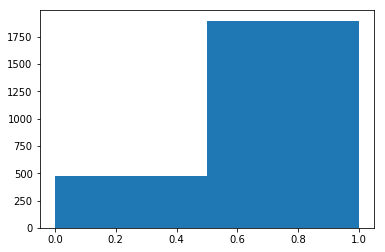

In [12]:
# Add plot
fig, ax = plt.subplots(1, 1)
# Add frequency plot
ax = plt.hist(ds_residues['LIP'], bins=2)

## Feature extraction

### Angles

In [13]:
# Define lists of angles phi and psi
phi, psi = list(), list()
# PePtideBuilder: build the peptides (reveal structure holes) and print sequences
ppb = PPBuilder()
# Loop thorugh every protein
for pdb_id in ds_original.pdb.unique():
    # Get structure of the protein
    structure = PDBParser(QUIET=True).get_structure(pdb_id, pdb_dir + '/pdb{}.ent'.format(pdb_id))
    # We select only the 0-th model
    model = structure[0]
    # Loop through every model's chain
    for chain in model:
        # Skip if the chain is not valid
        if (pdb_id, chain.id) not in valid_chains:
            continue
        # Loop through Peptides in the current chain
        for pp in ppb.build_peptides(chain):
            # Get phi and psi angles (rad)
            _phi, _psi = list(zip(*pp.get_phi_psi_list()))  # Separate psi, psi tuple
             # Concat angle lists
            phi += _phi
            psi += _psi

assert len(phi), len(ds_residues.shape[0])
assert len(psi), len(ds_residues.shape[0])

In [14]:
# Add PHI and PSI angles columns to residues dataset
ds_residues['PHI'] = pd.Series(phi)
ds_residues['PSI'] = pd.Series(psi)
ds_residues.head()

,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP,PHI,PSI
0,1cee,0,B,1,LYS,1,1,NaN,2.875877
1,1cee,0,B,2,LYS,1,1,-2.073664,0.462578
2,1cee,0,B,3,LYS,1,1,-1.271501,2.074690
3,1cee,0,B,4,ILE,1,1,-1.533032,2.537178
4,1cee,0,B,5,SER,1,1,-2.221338,2.645251


In [15]:
# Parse PHI and PSI from radiant to degree
ds_residues.PHI = ds_residues.PHI.apply(rad_to_deg,)
ds_residues.PSI = ds_residues.PSI.apply(rad_to_deg)
ds_residues.head()

,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP,PHI,PSI
0,1cee,0,B,1,LYS,1,1,NaN,164.775605
1,1cee,0,B,2,LYS,1,1,-118.812191,26.503750
2,1cee,0,B,3,LYS,1,1,-72.851646,118.870970
3,1cee,0,B,4,ILE,1,1,-87.836273,145.369609
4,1cee,0,B,5,SER,1,1,-127.273293,151.561732


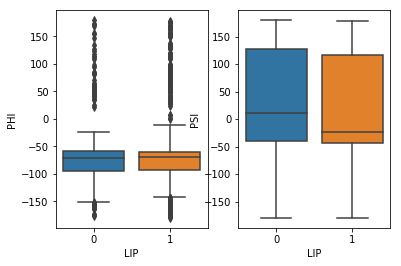

In [16]:
fig, ax = plt.subplots(1, 2)
sns.boxplot(x='LIP', y='PHI',data=ds_residues, ax=ax[0])
sns.boxplot(x='LIP', y='PSI',data=ds_residues, ax=ax[1])

### DSSP features

In [27]:
# Define protein
pdb_id = '1cee'
# Parse structure of the protein
structure = PDBParser(QUIET=True).get_structure(pdb_id, pdb_dir + '/pdb{}.ent'.format(pdb_id))
# Get first model
model = structure[0]
# Define DSSP instance of the 0-th model
dssp = DSSP(model, pdb_dir + '/pdb{}.ent'.format(pdb_id), dssp="/usr/local/bin/mkdssp")  # WARNING Check the path of mkdssp
# Loop through DSSP instance
# dssp index, amino acid, secondary structure, relative ASA, phi, psi,
# NH_O_1_relidx, NH_O_1_energy, O_NH_1_relidx, O_NH_1_energy, NH_O_2_relidx,
# NH_O_2_energy, O_NH_2_relidx, O_NH_2_energy
for ss in dssp:
    print(ss) 

(1, 'M', '-', 1.0, 360.0, 97.6, 0, 0.0, 2, -0.3, 0, 0.0, 50, -0.1)
(2, 'Q', '-', 0.3484848484848485, -91.3, 147.8, 48, -0.1, 50, -1.7, 51, -0.0, 2, -0.3)
(3, 'T', 'E', 0.3873239436619718, -142.6, 136.7, -2, -0.3, 50, -0.2, 48, -0.2, 2, -0.2)
(4, 'I', 'E', 0.005917159763313609, -94.3, 154.4, 48, -1.9, 50, -1.6, -2, -0.3, 2, -0.6)
(5, 'K', 'E', 0.3463414634146341, -112.5, 70.5, -2, -0.2, 71, -1.6, 48, -0.1, 2, -0.8)
(6, 'C', 'E', 0.0, -86.3, 107.8, 48, -1.8, 50, -3.0, -2, -0.6, 2, -0.4)
(7, 'V', 'E', 0.0, -112.8, 133.8, 70, -1.0, 72, -2.8, -2, -0.8, 2, -0.7)
(8, 'V', 'E', 0.007042253521126761, -86.5, 115.8, 48, -2.9, 50, -0.6, -2, -0.4, 2, -0.4)
(9, 'V', 'E', 0.035211267605633804, -113.0, 145.4, 70, -2.2, 72, -1.1, -2, -0.7, 2, -0.2)
(10, 'G', '-', 0.07142857142857142, 154.5, 148.8, -2, -0.4, 2, -0.5, 70, -0.2, 72, -0.1)
(11, 'D', 'S', 0.4049079754601227, -124.0, 100.0, -2, -0.2, 2, -0.3, 78, -0.1, 50, -0.1)
(12, 'G', 'S', 0.4880952380952381, 154.6, -166.2, -2, -0.5, 2, -0.7, 48, -0.4, 4

'dssp_dict = dict(dssp)\nfor model in structure:\n    for chain in model:\n        for residue in chain:\n            print(residue.get_full_id(), residue.get_resname(), dssp_dict.get((chain.id, residue.id)))\n            '

In [28]:
dssp_dict = dict(dssp)
for model in structure:
    for chain in model:
        for residue in chain:
            print(residue.get_full_id(), residue.get_resname(), dssp_dict.get((chain.id, residue.id)))

('1cee', 0, 'A', (' ', 1, ' ')) MET (1, 'M', '-', 1.0, 360.0, 97.6, 0, 0.0, 2, -0.3, 0, 0.0, 50, -0.1)
('1cee', 0, 'A', (' ', 2, ' ')) GLN (2, 'Q', '-', 0.3484848484848485, -91.3, 147.8, 48, -0.1, 50, -1.7, 51, -0.0, 2, -0.3)
('1cee', 0, 'A', (' ', 3, ' ')) THR (3, 'T', 'E', 0.3873239436619718, -142.6, 136.7, -2, -0.3, 50, -0.2, 48, -0.2, 2, -0.2)
('1cee', 0, 'A', (' ', 4, ' ')) ILE (4, 'I', 'E', 0.005917159763313609, -94.3, 154.4, 48, -1.9, 50, -1.6, -2, -0.3, 2, -0.6)
('1cee', 0, 'A', (' ', 5, ' ')) LYS (5, 'K', 'E', 0.3463414634146341, -112.5, 70.5, -2, -0.2, 71, -1.6, 48, -0.1, 2, -0.8)
('1cee', 0, 'A', (' ', 6, ' ')) CYS (6, 'C', 'E', 0.0, -86.3, 107.8, 48, -1.8, 50, -3.0, -2, -0.6, 2, -0.4)
('1cee', 0, 'A', (' ', 7, ' ')) VAL (7, 'V', 'E', 0.0, -112.8, 133.8, 70, -1.0, 72, -2.8, -2, -0.8, 2, -0.7)
('1cee', 0, 'A', (' ', 8, ' ')) VAL (8, 'V', 'E', 0.007042253521126761, -86.5, 115.8, 48, -2.9, 50, -0.6, -2, -0.4, 2, -0.4)
('1cee', 0, 'A', (' ', 9, ' ')) VAL (9, 'V', 'E', 0.03521126

('1cee', 4, 'A', (' ', 163, ' ')) LYS (163, 'K', 'T', 0.5756097560975609, -56.5, 102.0, 1, -0.3, -5, -0.3, 2, -0.1, -1, -0.2)
('1cee', 4, 'A', (' ', 164, ' ')) GLY (164, 'G', 'T', 0.34523809523809523, 57.8, 24.7, -2, -0.7, 4, -0.9, -7, -0.2, -1, -0.3)
('1cee', 4, 'A', (' ', 165, ' ')) LEU (165, 'L', 'H', 0.012195121951219513, -54.7, -79.9, -3, -2.1, 3, -1.8, 2, -0.2, 4, -0.8)
('1cee', 4, 'A', (' ', 166, ' ')) LYS (166, 'K', 'H', 0.4146341463414634, -54.9, -39.3, 1, -0.3, 4, -2.2, -4, -0.3, 3, -0.5)
('1cee', 4, 'A', (' ', 167, ' ')) ASN (167, 'N', 'H', 0.6178343949044586, -43.8, -31.6, 1, -0.3, 4, -0.6, 2, -0.2, -1, -0.3)
('1cee', 4, 'A', (' ', 168, ' ')) VAL (168, 'V', 'H', 0.007042253521126761, -71.7, -49.2, -3, -1.8, 4, -1.8, -4, -0.9, 3, -1.3)
('1cee', 4, 'A', (' ', 169, ' ')) PHE (169, 'F', 'H', 0.0, -60.6, -28.6, -4, -0.8, 4, -2.1, -3, -0.5, 5, -0.4)
('1cee', 4, 'A', (' ', 170, ' ')) ASP (170, 'D', 'H', 0.09202453987730061, -63.8, -29.7, -4, -2.2, 4, -1.1, 1, -0.2, -1, -0.3)
('1ce

('1cee', 9, 'A', (' ', 175, ' ')) ALA (175, 'A', 'H', 0.1509433962264151, -87.3, -49.6, -3, -1.8, -2, -0.3, -4, -1.0, -1, -0.2)
('1cee', 9, 'A', (' ', 176, ' ')) ALA (176, 'A', 'H', 0.009433962264150943, -50.9, -38.1, -4, -3.0, -2, -0.2, -5, -0.1, -3, -0.2)
('1cee', 9, 'A', (' ', 177, ' ')) LEU (177, 'L', 'S', 0.04878048780487805, -80.6, -172.9, -4, -3.1, 6, -0.1, -5, -0.2, -173, -0.0)
('1cee', 9, 'A', (' ', 178, ' ')) GLU (178, 'E', '-', 0.5927835051546392, -166.8, 161.1, 4, -0.5, -3, -0.1, 3, -0.0, -2, -0.0)
('1cee', 9, 'A', (' ', 179, ' ')) PRO (179, 'P', '-', 0.7647058823529411, -43.1, 360.0, 0, 0.0, 3, -3.3, 0, 0.0, 4, -0.5)
('1cee', 9, 'A', ('H_ MG', 180, ' '))  MG None
('1cee', 9, 'A', ('H_GCP', 181, ' ')) GCP None
('1cee', 9, 'B', (' ', 1, ' ')) LYS (181, 'K', '-', 1.0, 360.0, 164.8, 0, 0.0, -3, -0.0, 0, 0.0, 0, 0.0)
('1cee', 9, 'B', (' ', 2, ' ')) LYS (182, 'K', '-', 0.2926829268292683, -118.8, 26.5, -3, -3.3, 2, -0.5, 2, -0.1, -4, -0.5)
('1cee', 9, 'B', (' ', 3, ' ')) LYS (18

('1cee', 14, 'B', (' ', 14, ' ')) GLY (194, 'G', '-', 0.38095238095238093, 164.3, 40.4, -170, -0.3, -153, -0.1, -152, -0.1, 2, -0.1)
('1cee', 14, 'B', (' ', 15, ' ')) PHE (195, 'F', '-', 0.39593908629441626, -48.4, 111.0, -171, -0.3, 2, -0.6, -153, -0.1, -153, -0.2)
('1cee', 14, 'B', (' ', 16, ' ')) LYS (196, 'K', 'E', 0.6, -116.9, 100.9, -155, -1.6, 2, -2.0, -2, -0.1, -155, -1.7)
('1cee', 14, 'B', (' ', 17, ' ')) HIS (197, 'H', 'E', 0.41304347826086957, -67.3, 85.5, -2, -0.6, -157, -0.2, 1, -0.2, 3, -0.2)
('1cee', 14, 'B', (' ', 18, ' ')) VAL (198, 'V', 'E', 0.2746478873239437, -69.8, -28.5, -2, -2.0, 2, -0.3, -159, -1.6, -1, -0.2)
('1cee', 14, 'B', (' ', 19, ' ')) SER (199, 'S', 'E', 0.0, -162.6, 140.2, -160, -1.4, -160, -0.9, -3, -0.2, 2, -0.5)
('1cee', 14, 'B', (' ', 20, ' ')) HIS (200, 'H', 'E', 0.4076086956521739, -128.8, 116.5, -2, -0.3, 12, -0.9, -162, -0.2, 2, -0.6)
('1cee', 14, 'B', (' ', 21, ' ')) VAL (201, 'V', 'E', 0.007042253521126761, -115.6, 110.6, -164, -1.1, 2, -0.7, 

('1cee', 19, 'B', (' ', 14, ' ')) GLY (194, 'G', '-', 0.38095238095238093, 164.3, 40.4, -170, -0.3, -153, -0.1, -152, -0.1, 2, -0.1)
('1cee', 19, 'B', (' ', 15, ' ')) PHE (195, 'F', '-', 0.39593908629441626, -48.4, 111.0, -171, -0.3, 2, -0.6, -153, -0.1, -153, -0.2)
('1cee', 19, 'B', (' ', 16, ' ')) LYS (196, 'K', 'E', 0.6, -116.9, 100.9, -155, -1.6, 2, -2.0, -2, -0.1, -155, -1.7)
('1cee', 19, 'B', (' ', 17, ' ')) HIS (197, 'H', 'E', 0.41304347826086957, -67.3, 85.5, -2, -0.6, -157, -0.2, 1, -0.2, 3, -0.2)
('1cee', 19, 'B', (' ', 18, ' ')) VAL (198, 'V', 'E', 0.2746478873239437, -69.8, -28.5, -2, -2.0, 2, -0.3, -159, -1.6, -1, -0.2)
('1cee', 19, 'B', (' ', 19, ' ')) SER (199, 'S', 'E', 0.0, -162.6, 140.2, -160, -1.4, -160, -0.9, -3, -0.2, 2, -0.5)
('1cee', 19, 'B', (' ', 20, ' ')) HIS (200, 'H', 'E', 0.4076086956521739, -128.8, 116.5, -2, -0.3, 12, -0.9, -162, -0.2, 2, -0.6)
('1cee', 19, 'B', (' ', 21, ' ')) VAL (201, 'V', 'E', 0.007042253521126761, -115.6, 110.6, -164, -1.1, 2, -0.7, 